In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import zscore

from collections import Counter, defaultdict

import sys
import os
import re
sys.path.append(os.path.relpath("../helper"))

import name_mappings


In [7]:
cell_line_info = pd.read_csv("raw/depmap/DepMap-2018q4-celllines.csv",index_col=0)

# Gencode v19 definitions

In [3]:
g19_definitions = pd.read_csv("raw/ccle/gencode.v19.genes.v7_model.patched_contigs.gtf",sep="\t",skiprows=6,
                              names=["chrom","source","type","start","end",".1","strand",".2","info"])

g19_definitions["ensembl_gene_id"] = g19_definitions["info"].apply(
    lambda x: x.split(";")[0][9:-1])
g19_definitions["gene_name"] = g19_definitions["info"].apply(
    lambda x: x.split("gene_name")[1].split(";")[0][2:-1])
g19_definitions["ensembl_tx_id"] = g19_definitions["info"].apply(
    lambda x: x.split("transcript_id")[1].split(";")[0][2:-1])

g19_gene_definitions = g19_definitions[g19_definitions["type"]=="gene"]

ensembl_id_map = dict(zip(g19_gene_definitions["ensembl_gene_id"],g19_gene_definitions["gene_name"]))
ensembl_id_map = defaultdict(str, ensembl_id_map)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
g19_definitions.to_hdf("processed/ccle/gencode.v19.genes.v7_model.patched_contigs.h5",
                       key="g19_definitions",
                       mode="w")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['chrom', 'source', 'type', '.1', 'strand', '.2', 'info', 'ensembl_gene_id', 'gene_name', 'ensembl_tx_id']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# Chromatin profiling

In [55]:
chromatin_profiling = pd.read_csv("raw/ccle/CCLE_GlobalChromatinProfiling_20181130.csv",index_col=1).iloc[:,1:]
chromatin_profiling.to_hdf("processed/ccle/CCLE_GlobalChromatinProfiling_20181130.hdf",
                           key="chromatin_profiling",
                           mode="w")


# RPPA

In [57]:
rppa = pd.read_csv("raw/ccle/CCLE_RPPA_20181003.csv",index_col=0)
rppa.index = rppa.index.map(lambda x: name_mappings.name_map[x])
rppa.to_hdf("processed/ccle/CCLE_RPPA_20181003.hdf",
            key="rppa",
            mode="w")

# RNAseq

## Exonusage

In [2]:
def reorder_exon(exon):
    exon_split = exon.split("_")
    return "_".join(exon_split[3:]) + "_" + "_".join(exon_split[:3])

exonusage = pd.read_csv("raw/ccle/CCLE_RNAseq_ExonUsageRatio_20180929.gct",skiprows=2,index_col=0,sep="\t")
exonusage.index = exonusage.index.map(lambda x:reorder_exon(x))

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9,89,101,117,158,251,322,341,556,559,613,817,825,853,900,912,971,984,993) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
exonusage[exonusage=="\tNA"] = np.nan
exonusage[exonusage=="    NA"] = np.nan
exonusage[exonusage=="     NA"] = np.nan
exonusage = exonusage.astype(float)

In [3]:
exon_ids = pd.Series(exonusage.index,index=exonusage.index) + "_" + pd.Series(exonusage["gene_id"])
exonusage = exonusage.set_index(exon_ids).iloc[:,1:]
exonusage = exonusage.T
exonusage.index = exonusage.index.map(lambda x: name_mappings.name_map[x])

In [ ]:
exonusage_nans = exonusage.isna().sum(axis=0)
sns.distplot(exonusage_nans)
exonusage = exonusage[exonusage.columns[exonusage_nans<800]]

In [26]:
exonusage_stdevs = exonusage.std(axis=0)
sns.distplot(exonusage_stdevs)
exonusage = exonusage[exonusage.columns[exonusage_stdevs>0.1]]

In [53]:
exonusage.to_hdf("processed/ccle/CCLE_RNAseq_ExonUsageRatio_20180929.hdf",
                 key="exonusage",
                 mode="w")

## Intron retention

In [2]:
intronret = pd.read_csv("raw/ccle/CCLE_intron_retention.csv",index_col=0)
intronret.columns = ["_".join(x.split(";")[::-1]) for x in intronret.columns]
intronret.index = intronret.index.map(lambda x: name_mappings.name_map[x])

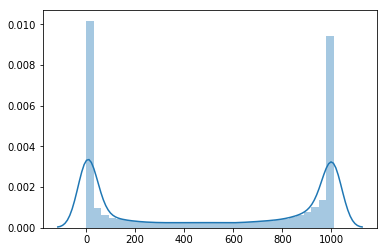

In [37]:
intronret_nans = intronret.isna().sum(axis=0)
sns.distplot(intronret_nans)
intronret = intronret[intronret.columns[intronret_nans<800]]

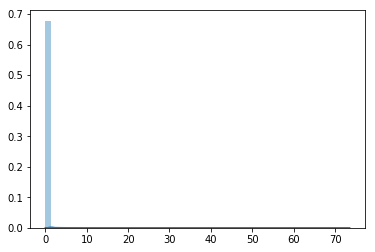

In [50]:
intronret_stdevs = intronret.std(axis=0)
sns.distplot(intronret_stdevs)
intronret = intronret[intronret.columns[intronret_stdevs>0.1]]

In [53]:
intronret.to_hdf("processed/ccle/CCLE_intron_retention.hdf",
                 key="intronret",
                 mode="w")

## Transcript expression

In [58]:
ccle_transcripts = pd.read_csv("raw/ccle/CCLE_RNAseq_rsem_transcripts_tpm_20180929.txt",sep="\t",index_col=1)
ccle_transcripts["gene_id"] = ccle_transcripts["gene_id"].apply(lambda x: ensembl_id_map[x])


In [78]:
gene_transcript_ids = ccle_transcripts["gene_id"] + "_" + pd.Series(ccle_transcripts.index,index=ccle_transcripts.index)
ccle_transcripts = ccle_transcripts.set_index(gene_transcript_ids)

In [80]:
ccle_transcripts = ccle_transcripts.iloc[:,1:]
ccle_transcripts = np.log2(ccle_transcripts+1)
ccle_transcripts = ccle_transcripts.T
ccle_transcripts.index = ccle_transcripts.index.map(lambda x: name_mappings.name_map[x])

In [95]:
ccle_transcript_stdevs = ccle_transcripts.std(axis=0)
sns.distplot(ccle_transcript_stdevs)
ccle_transcripts = ccle_transcripts[ccle_transcripts.columns[ccle_transcript_stdevs>0.25]]

In [104]:
ccle_transcripts.to_hdf("processed/ccle/CCLE_RNAseq_rsem_transcripts_tpm_20180929.hdf",
                        key="ccle_transcripts",
                        mode="w")

## Gene expression

In [106]:
ccle_genex = pd.read_csv("raw/ccle/CCLE_RNAseq_rsem_genes_tpm_20180929.txt",sep="\t",index_col=0)

ccle_genex = ccle_genex.iloc[:,1:]
ccle_gene_names = ccle_genex.index.map(lambda x: ensembl_id_map[x])
gene_names_ids = ccle_gene_names + "_" + pd.Series(ccle_genex.index,index=ccle_genex.index)
ccle_genex = ccle_genex.set_index(gene_names_ids)
ccle_genex = np.log2(ccle_genex+1)
ccle_genex = ccle_genex.T
ccle_genex.index = ccle_genex.index.map(lambda x: name_mappings.name_map[x])

In [116]:
ccle_genex.to_hdf("processed/ccle/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",
                  key="ccle_genex",
                  mode="w")

## RPKM expression

In [4]:
ccle_genex = pd.read_csv("raw/ccle/CCLE_RNAseq_genes_rpkm_20180929.gct",sep="\t",index_col=0,skiprows=2)

gene_names_ids = ccle_genex["Description"] + "_" + ccle_genex.index
ccle_genex = ccle_genex.iloc[:,1:]
ccle_genex = ccle_genex.set_index(gene_names_ids)
ccle_genex = np.log2(ccle_genex+1)
ccle_genex = ccle_genex.T
ccle_genex.index = ccle_genex.index.map(lambda x: name_mappings.name_map[x])

In [8]:
ccle_genex.to_hdf("processed/ccle/CCLE_RNAseq_genes_rpkm_20180929.hdf",
                  key="ccle_genex",
                  mode="w")

## ssGSEA

In [7]:
name_map = dict(zip(cell_line_info["CCLE_Name"],cell_line_info.index))

In [23]:
ssgsea = pd.read_csv("raw/ccle/GSEA_RNAseq.csv",index_col=0)
ssgsea = ssgsea[ssgsea.index.isin(name_map.keys())]
ssgsea.index = ssgsea.index.map(lambda x: name_map[x])
ssgsea = ssgsea.dropna(thresh=50,axis=0)

In [28]:
ssgsea.to_hdf("processed/ccle/GSEA_RNAseq.hdf",
              key="ssgsea",
              mode="w")

# RRBS

## CpG islands

In [38]:
cgi_meth = pd.read_csv("raw/ccle/CCLE_RRBS_cgi_CpG_clusters_20181119.txt",sep="\t",index_col=0)
cgi_meth = cgi_meth.iloc[:-1]
cgi_meth["cluster_pos"] = cgi_meth.index
cgi_meth['cluster_n'] = cgi_meth.groupby('cluster_pos').cumcount()+1
cgi_meth.index = cgi_meth["cluster_pos"].astype(str) + "-" + cgi_meth["cluster_n"].astype(str)

cgi_meth = cgi_meth.iloc[:,2:-2]
cgi_meth = cgi_meth.T
cgi_meth = cgi_meth.astype(np.float32)
cgi_meth.index = cgi_meth.index.map(lambda x: name_mappings.name_map[x])

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


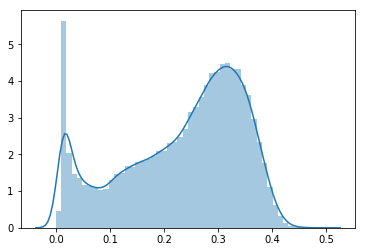

In [55]:
cgi_meth_stds = cgi_meth.std(axis=0)
sns.distplot(cgi_meth_stds)
cgi_meth = cgi_meth[cgi_meth.columns[cgi_meth_stds>0.05]]

In [56]:
cgi_meth.to_hdf("processed/ccle/CCLE_RRBS_cgi_CpG_clusters_20181119.hdf",
                key="cgi_meth",
                mode="w")

## Enhancers

In [29]:
enh_meth = pd.read_csv("raw/ccle/CCLE_RRBS_enh_CpG_clusters_20181119.txt",sep="\t",index_col=0)
enh_meth.index = enh_meth.index + "_" + enh_meth.groupby(level=0).cumcount().astype(str)

enh_meth = enh_meth.iloc[:,2:]
enh_meth.index = enh_meth.index.map(lambda x: x.replace("_","-"))+"_enh"
enh_meth = enh_meth.T
enh_meth.index = enh_meth.index.map(lambda x: name_mappings.name_map[x])

In [31]:
enh_meth[enh_meth=="\tNA"] = np.nan
enh_meth[enh_meth=="    NA"] = np.nan
enh_meth[enh_meth=="     NA"] = np.nan
enh_meth = enh_meth.astype(float)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


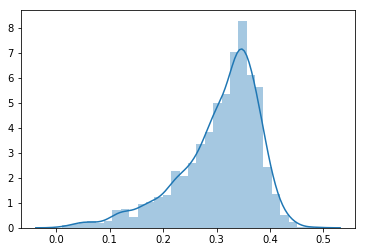

In [32]:
enh_meth_stds = enh_meth.std(axis=0)
sns.distplot(enh_meth_stds)
enh_meth = enh_meth[enh_meth.columns[enh_meth_stds>0.05]]

In [33]:
enh_meth.to_hdf("processed/ccle/CCLE_RRBS_enh_CpG_clusters_20181119.hdf",
                key="enh_meth",
                mode="w")

## TSS 1kb

In [21]:
tss1kb_meth = pd.read_csv("raw/ccle/CCLE_RRBS_TSS1kb_20181022.txt",sep="\t",index_col=0)
tss1kb_meth = tss1kb_meth.iloc[:-1,2:]
tss1kb_meth = tss1kb_meth.T
tss1kb_meth.index = tss1kb_meth.index.map(lambda x: name_mappings.name_map[x])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,618) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
tss1kb_meth[tss1kb_meth=="\tNA"] = np.nan
tss1kb_meth[tss1kb_meth=="    NA"] = np.nan
tss1kb_meth[tss1kb_meth=="     NA"] = np.nan
tss1kb_meth = tss1kb_meth.astype(float)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


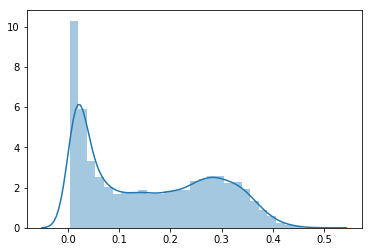

In [23]:
tss1kb_meth_stds = tss1kb_meth.std(axis=0)
sns.distplot(tss1kb_meth_stds)
tss1kb_meth = tss1kb_meth[tss1kb_meth.columns[tss1kb_meth_stds>0.05]]

In [24]:
tss1kb_meth.to_hdf("processed/ccle/CCLE_RRBS_TSS1kb_20181022.hdf",
                   key="tss1kb_meth",
                   mode="w"
                  )

## TSS clusters

In [133]:
tssclust_meth = pd.read_csv("raw/ccle/CCLE_RRBS_tss_CpG_clusters_20181022.txt",sep="\t",index_col=0)
tssclust_meth = tssclust_meth.iloc[:-1,2:]
tssclust_meth = tssclust_meth.T
tssclust_meth.index = tssclust_meth.index.map(lambda x: name_mappings.name_map[x])

In [144]:
tssclust_meth[tssclust_meth=="\tNA"] = np.nan
tssclust_meth[tssclust_meth=="    NA"] = np.nan
tssclust_meth[tssclust_meth=="     NA"] = np.nan
tssclust_meth = tssclust_meth.astype(float)

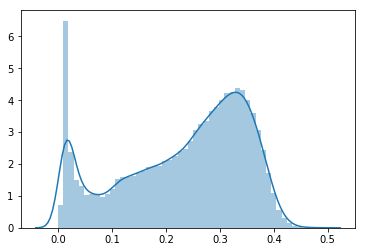

In [150]:
tssclust_meth_stds = tssclust_meth.std(axis=0)
sns.distplot(tssclust_meth_stds)
tssclust_meth = tssclust_meth[tssclust_meth.columns[tssclust_meth_stds>0.05]]

In [158]:
tssclust_meth.to_hdf("processed/ccle/CCLE_RRBS_tss_CpG_clusters_20181022.hdf",key="tssclust_meth")

# miRNA

In [19]:
mirna = pd.read_csv("raw/ccle/CCLE_miRNA_20181103.gct.txt",sep="\t",skiprows=2)
mirna.index = mirna["Description"] + "_" + mirna["Name"].apply(lambda x: x[1:])

mirna = mirna.iloc[:,2:]
mirna = np.log2(mirna.T)

mirna.index = mirna.index.map(lambda x: name_mappings.name_map[x])

In [20]:
mirna.to_hdf("processed/ccle/CCLE_miRNA_20181103.hdf", key="mirna", mode="w")

# Proteomics

In [3]:
proteomics = pd.read_csv("raw/ccle/protein_quant_current_normalized.csv")
proteomics.index = proteomics["Gene_Symbol"] + "_" + proteomics["Protein_Id"]
proteomics.index = proteomics.index.astype(str) + "_" + proteomics.groupby(level=0).cumcount().astype(str)

proteomics = proteomics.iloc[:,48:]
proteomics = proteomics.T
proteomics.index = proteomics.index.map(lambda x:x.split("_Ten")[0])
proteomics.index = proteomics.index.map(lambda x: name_mappings.name_map[x])
proteomics = proteomics[~proteomics.index.duplicated(keep='first')]

In [4]:
proteomics.to_hdf("processed/ccle/protein_quant_current_normalized.hdf",
                  key="proteomics",
                  mode="w")

# TERT promoter

In [18]:
tertp_info = pd.read_csv("raw/ccle/Supplementary_Table_2_TERT_promoter_mutation.csv",index_col=0)

tertp_info.index = tertp_info.index.map(lambda x: name_mappings.name_map[x])

tertp_info["tertp_mut"] = tertp_info["Classical_Promoter_Mutations"] != "wildtype"

tertp_info.to_hdf("processed/ccle/Supplementary_Table_2_TERT_promoter_mutation.h5",
                  key="tertp_info",
                  mode="w")

# WES/WGS mutation calls

In [4]:
genome_muts = pd.read_csv("raw/ccle/ccle2maf_ExcludSangerDriftedSubset_20180820.txt",
                          sep="\t")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,25,26,27,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Drug sensitivities

In [9]:
primary_mad = pd.read_csv("raw/ccle/primary-screen-public-tentative_v4-primary-merged-mad-lfcvc-cb.csv",
                         index_col=0)
primary_median = pd.read_csv("raw/ccle/primary-screen-public-tentative_v4-primary-merged-median-lfcvc-cb.csv",
                            index_col=0)
primary_meta = pd.read_csv("raw/ccle/primary-screen-public-tentative_v4-primary-merged-row-meta.csv")

secondary_mad = pd.read_csv("raw/ccle/secondary-screen-public-tentative_v3-secondary-merged-mad-lfcvc-cb.csv",
                           index_col=0)
secondary_median = pd.read_csv("raw/ccle/secondary-screen-public-tentative_v3-secondary-merged-median-lfcvc-cb.csv",
                              index_col=0)
secondary_meta = pd.read_csv("raw/ccle/secondary-screen-public-tentative_v3-secondary-merged-row-meta.csv")

primary_name_map = dict(zip(primary_meta["feature_id"],primary_meta["depmap_id"]))
secondary_name_map = dict(zip(secondary_meta["feature_id"],secondary_meta["depmap_id"]))



In [14]:
primary_mad.index = primary_mad.index.map(lambda x: primary_name_map[x])
primary_median.index = primary_median.index.map(lambda x: primary_name_map[x])

secondary_mad.index = secondary_mad.index.map(lambda x: secondary_name_map[x])
secondary_median.index = secondary_median.index.map(lambda x: secondary_name_map[x])

In [16]:
primary_mad.to_hdf(
    "processed/ccle/primary-screen-public-tentative_v4-primary-merged-mad-lfcvc-cb.h5", 
    key="primary_mad",
    mode="w")
primary_median.to_hdf(
    "processed/ccle/primary-screen-public-tentative_v4-primary-merged-median-lfcvc-cb.h5", 
    key="primary_median",
    mode="w")

secondary_mad.to_hdf(
    "processed/ccle/secondary-screen-public-tentative_v3-secondary-merged-mad-lfcvc-cb.h5", 
    key="secondary_mad",
    mode="w")
secondary_median.to_hdf(
    "processed/ccle/secondary-screen-public-tentative_v3-secondary-merged-median-lfcvc-cb.h5", 
    key="secondary_median",
    mode="w")

# Raw mutation data

In [4]:
mutation_calls = pd.read_csv("../data/raw/depmap/CCLE_mutations_19q4.csv",index_col=0)

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,20,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
damaging_muts = mutation_calls[mutation_calls["Variant_annotation"]=="damaging"]
hs_muts = mutation_calls[(mutation_calls["isCOSMIChotspot"]==True)|(mutation_calls["isTCGAhotspot"]==True)]

damaging_counts = Counter(damaging_muts["Hugo_Symbol"])
hs_counts = Counter(hs_muts["Hugo_Symbol"])

damaging_muts["count"] = damaging_muts["Hugo_Symbol"].apply(lambda x: damaging_counts[x])
hs_muts["count"] = hs_muts["Hugo_Symbol"].apply(lambda x: hs_counts[x])

damaging_muts = damaging_muts[damaging_muts["count"]>=4]
hs_muts = hs_muts[hs_muts["count"]>=4]

damaging_muts["id"] = damaging_muts["Hugo_Symbol"] + "_" + damaging_muts["DepMap_ID"]
hs_muts["id"] = hs_muts["Hugo_Symbol"] + "_" + hs_muts["DepMap_ID"]

damaging_muts = damaging_muts.drop_duplicates(subset=["id"],keep="first")
hs_muts = hs_muts.drop_duplicates(subset=["id"],keep="first")

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
hs_muts["value"] = 1
damaging_muts["value"] = 1

hs_mut_mat = pd.pivot_table(hs_muts, values="value", index=[
                            "DepMap_ID"], columns="Hugo_Symbol", fill_value=0)
damaging_mut_mat = pd.pivot_table(damaging_muts, values="value", index=[
                                  "DepMap_ID"], columns="Hugo_Symbol", fill_value=0)

In [7]:
hs_mut_mat.to_hdf("processed/ccle/hs_mut_mat.hdf",key="hs_mut_mat",mode="w")
damaging_mut_mat.to_hdf("processed/ccle/damaging_mut_mat.hdf",key="damaging_mut_mat",mode="w")

# Binary calls for CNA/mutations

In [3]:
revealer = pd.read_csv("raw/ccle/CCLE_MUT_CNA_AMP_DEL_binary_Revealer.gct",
                       skiprows=2, index_col=0, sep="\t").iloc[:, 1:].T
revealer = revealer.drop("UMRC6_KIDNEY",axis=0)

revealer.index = revealer.index.map(lambda x: name_mappings.name_map[x])
revealer.to_hdf("processed/ccle/CCLE_MUT_CNA_AMP_DEL_binary_Revealer.hdf",key="revealer",mode="w")

# ssGSEA (new)

In [12]:
oncogenic = pd.read_csv("raw/ccle/CCLE_RNAseq_genes_rpkm_20180929.ssgsea_ONCOGENIC.gct",
                       sep="\t",
                       index_col=0,
                       skiprows=2
                      )
hallmark = pd.read_csv("raw/ccle/CCLE_RNAseq_genes_rpkm_20180929.ssgsea_HALLMARK.gct",
                       sep="\t",
                       index_col=0,
                       skiprows=2
                      )
senescence = pd.read_csv("raw/ccle/CCLE_RNAseq_genes_rpkm_20180929.ssgsea_SENESCENCE.gct",
                       sep="\t",
                       index_col=0,
                       skiprows=2
                      )
oncogenic = oncogenic.iloc[:,1:].T
hallmark = hallmark.iloc[:,1:].T
senescence = senescence.iloc[:,1:].T

oncogenic = oncogenic.apply(zscore)
hallmark = hallmark.apply(zscore)
senescence = senescence.apply(zscore)

ssgsea = pd.concat([oncogenic,hallmark,senescence],axis=1,sort=True)
ssgsea.index = ssgsea.index.map(lambda x: name_mappings.name_map[x])
ssgsea.to_hdf("processed/ccle/ssgsea.hdf",key="ssgsea",mode="w")

# Protein levels

In [34]:
ms_prot = pd.read_excel("../data/raw/ccle/Table_S2_Protein_Quant_Normalized.xlsx",sheet_name="Normalized Protein Expression")
ms_prot = ms_prot[[x for x in ms_prot if x[:6] != "Column"]]
ms_prot["Protein_Id"] = ms_prot["Gene_Symbol"] + "_" + ms_prot["Protein_Id"]
ms_prot = ms_prot.set_index("Protein_Id")
ms_prot = ms_prot.iloc[:,47:]
ms_prot = ms_prot.T

ms_prot.index = ms_prot.index.map(lambda x: "_".join(x.split("_")[:-1]))
ms_prot.index = ms_prot.index.map(lambda x: name_mappings.name_map[x])

ms_prot.columns = [str(ms_prot.columns[i]) + "_" + str(i) for i in range(len(ms_prot.columns))]
ms_prot = ms_prot[~ms_prot.index.duplicated(keep="first")]

In [49]:
ms_prot.to_hdf("../data/processed/ccle/ms_prot.h5",key="ms_prot",mode="w")